In [1]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Логистическая регрессия

## Классификация с помощью линейной регрессии

In [2]:
cancer = load_iris()

In [3]:
data = cancer.data
fn = cancer.feature_names

In [4]:
fn

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [5]:
cancer.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [6]:
scaler = StandardScaler()

In [7]:
tsne = TSNE(n_components=2)

In [8]:
tsne_data = tsne.fit_transform(scaler.fit_transform(data))

C:\Users\anesterenko\Miniconda3\envs\MLIsuct\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\anesterenko\Miniconda3\envs\MLIsuct\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<p>В некоторых задачах классификации, мы бы хотели разделить классы с помощью линейной плоскости, поскольку данные хорошо подходят для этого алгоритма</p>

In [9]:
lin_r = LinearRegression()

In [10]:
cancer.target[cancer.target != 0] = 1
cancer.target[cancer.target == 0] = 0

In [11]:
plt.style.use('seaborn')

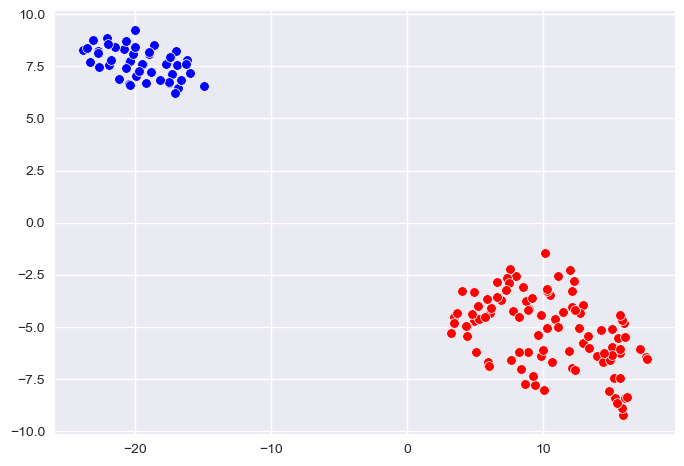

In [12]:
sns.scatterplot(x=tsne_data[cancer.target == 0, 0], y=tsne_data[cancer.target == 0, 1], color='b');
sns.scatterplot(x=tsne_data[cancer.target == 1, 0], y=tsne_data[cancer.target == 1, 1], color='r');

In [13]:
lin_r.fit(tsne_data, cancer.target)

LinearRegression()

In [14]:
lin_r.coef_

array([ 0.01500226, -0.03946054], dtype=float32)

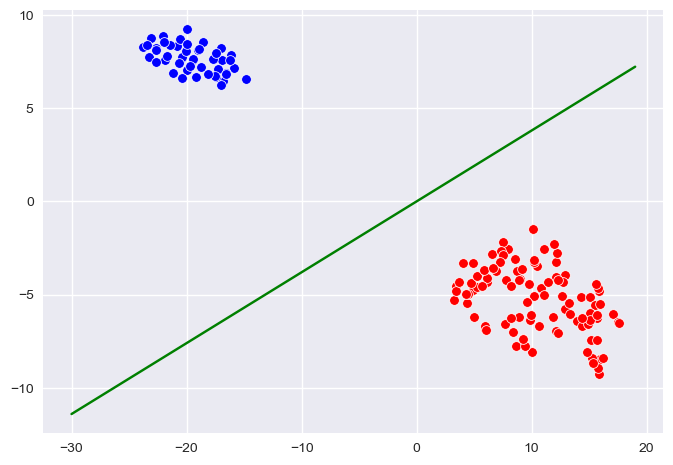

In [15]:
sns.scatterplot(x=tsne_data[cancer.target == 0, 0], y=tsne_data[cancer.target == 0, 1], color='b');
sns.scatterplot(x=tsne_data[cancer.target == 1, 0], y=tsne_data[cancer.target == 1, 1], color='r');
plt.plot(np.arange(-30, 20), -np.arange(-30, 20)*lin_r.coef_[0]/lin_r.coef_[1], c='g');

<p>Это возможно если мы дадим метки классам {-1;1} и будем тренировать алгоритм как обычно, в этом случае точки ниже линии будут отрицательного класса, а выше положительного.</p>
<p>Однако это не является лучшим выбором поскольку мы не можем сказать с какой уверенностью алгоритм дает ответ пренадлежности к тому или иному классу</p>

## Отступ

In [16]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

<p>В качестве меры уверенности, логичным решением является использование расстояние от точки до разделяющей прямой, данное расстояние называется отступом и обозначается M(x)</p>
<p>Кроме того у отступа имеется знак и он положителен если текущая точка находится на стороне своего класса и отрицателен если наоборот</p>
<p><center>$$\large{M(x_i) = [y_i == y_c]<x_iw>}$$</center></p>
<img src="./img/margin.png">
<p>Отступ показывает уверенность нашего предсказания, однако мы бы хотели опрерировать вероятностями пренадлежности класса, для этого нам необходима функция которая бы переводила значение из отрезка ($-\infty;+\infty$) в отрезок (0; 1). Так же желательно чтобы данная функция была дифференцируема, одним из лучших выборов для данных ограниченией является сигмоид функция</p>
<p><center>$$\large{\sigma = \frac{1}{1+\exp^{(-M(x))}}}$$</center></p>
<p>Так же важно что производная сигмоид функции, очень близка к нормальному распределению</p>

In [17]:
def sigmoid_deveriate(x):
    return sigmoid(x)*(1-sigmoid(x))

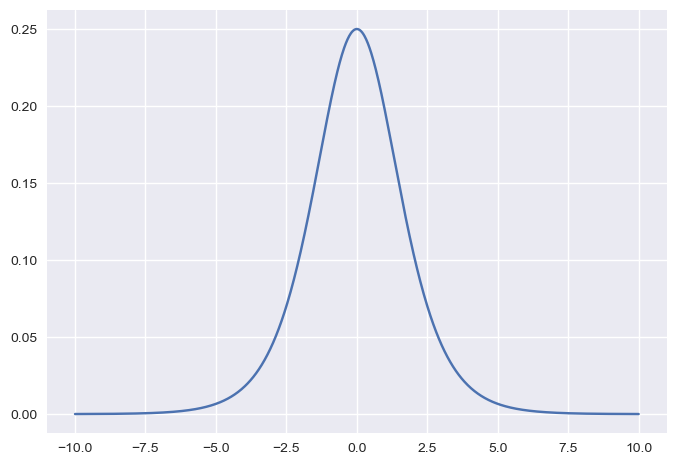

In [18]:
plt.plot(np.linspace(-10, 10, 1000), [sigmoid_deveriate(var) for var in np.linspace(-10, 10, 1000)]);

<p>Еще одним условием для построения хорошей модели линейного разделения классов, это изменение функции оптимизация с квадратичной ошибки на что-то другое</p>
<p>Наилучшим способом является оптимизации функции правдоподобия, данная функция показывает насколько ответы алгоритма правдоподобны данным</p>
<p><center>$$\large{L=\prod_{i=1}^{N}p(y_i|\sigma_i)}$$</center></p>

- $p(y_i|\sigma_i) = \sigma$ для положительного класса 
- $p(y_i|\sigma_i) = 1 - \sigma$ для отрицательного класса

<p>Недостатоком этой функции, является сложное дифференцирование, из-за произведения внутри нее, однако данная проблема легко обходится взятием логарифма, которые преобразует произведение в сумму</p>
<p><center>$$\large{L=\sum_{i=1}^{N}[y\log(\sigma)+(1-y)\log(1-\sigma)]}$$</center></p>
<p>Модель минимизирующая отступ, путем минимизации отрицательной функции логарифмического правдопобия называется логистической регрессией</p>
<p>Данная модель представленна классом LogisticRegression, в библиотеке sklearn модуля liner_models</p>
<p>Параметры модели:</p>

- penalty - регуляризация модели (l1, l2, elasticnet)
- C - сила регуляризации

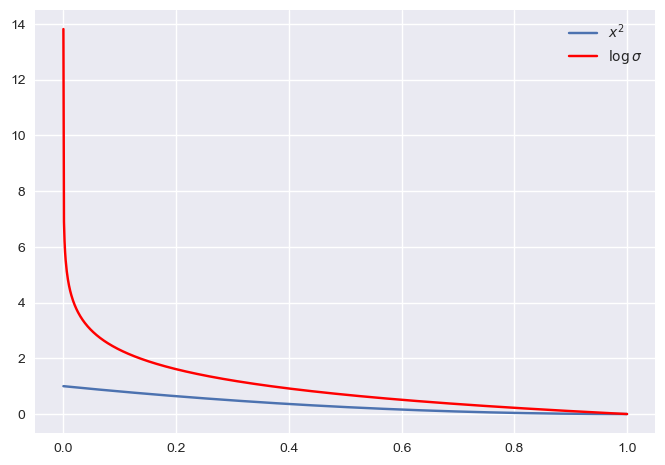

In [19]:
plt.plot(np.linspace(1e-6, 1, 1000), (1 - np.linspace(1e-6, 1, 1000))**2, label='$x^2$');
plt.plot(np.linspace(1e-6, 1, 1000), -np.log(np.linspace(1e-6, 1, 1000)), label='$\log{\sigma}$', c='r');
plt.legend();

In [20]:
weights = np.random.rand(3)
weights[-1] = 0
learning_rate = 0.01

for i in range(1000):
    index = np.random.randint(tsne_data.shape[0])
    value = np.ones(3)
    value[:2] = tsne_data[index]
    answer = cancer.target[index]
    
    z = value.dot(weights)
    sigma = sigmoid(z)
    diff = (answer - sigma) * value
    weights = weights - learning_rate * diff
    if (i + 1) / 100 == 0:
        learning_rate /= 2

C:\Users\anesterenko\AppData\Local\Temp\ipykernel_9888\4033946986.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


In [21]:
k = - weights[0] / weights[1]
b = - weights[2] / weights[1]

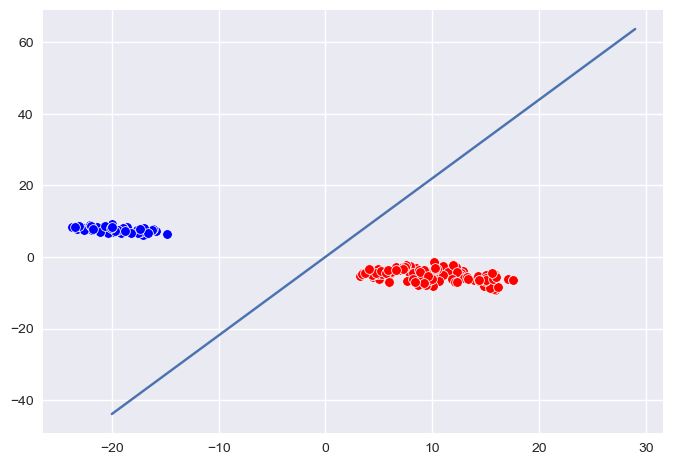

In [22]:
sns.scatterplot(x=tsne_data[cancer.target == 0, 0], y=tsne_data[cancer.target == 0, 1], color='b');
sns.scatterplot(x=tsne_data[cancer.target == 1, 0], y=tsne_data[cancer.target == 1, 1], color='r');
plt.plot(np.arange(-20, 30), k * np.arange(-20, 30) + b)

In [23]:
lr = LogisticRegression()

In [24]:
lr.fit(tsne_data, cancer.target)

LogisticRegression()

In [25]:
tsne_data[cancer.target == -1,0]

array([], dtype=float32)

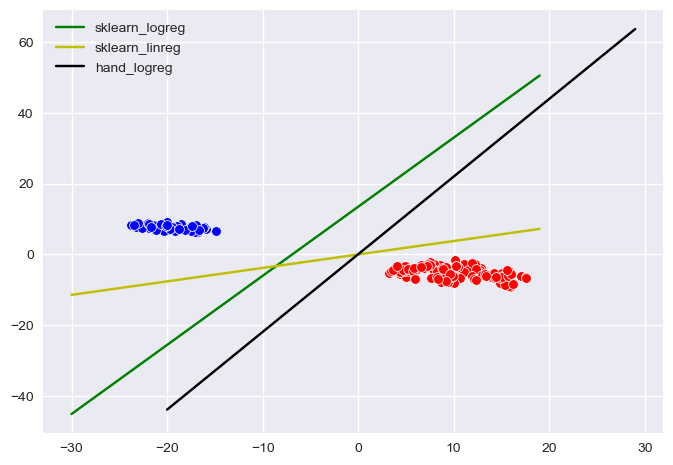

In [27]:
sns.scatterplot(x=tsne_data[cancer.target == 0, 0], y=tsne_data[cancer.target == 0, 1], color='b');
sns.scatterplot(x=tsne_data[cancer.target == 1, 0], y=tsne_data[cancer.target == 1, 1], color='r');
plt.plot(np.arange(-30, 20), (-np.arange(-30, 20)*lr.coef_[0, 0] - lr.intercept_)/lr.coef_[0, 1], c='g', label="sklearn_logreg");
plt.plot(np.arange(-30, 20), -np.arange(-30, 20)*lin_r.coef_[0]/lin_r.coef_[1], c='y', label="sklearn_linreg");
plt.plot(np.arange(-20, 30), k * np.arange(-20, 30) + b, c='black', label="hand_logreg");
plt.legend()